In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [2]:
# Ignore Convergence Warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df_complete = pd.read_csv('../data/data_complete.csv')
df_mean = pd.read_csv('../data/data_mean.csv', index_col=0)
df_ml = pd.read_csv('../data/data_ml.csv', index_col=0)
df_mice = pd.read_csv('../data/data_mice.csv')

In [4]:
sum(df_mice.isna().any())

1

In [5]:
sum(df_mean.isna().any())

1

In [6]:
sum(df_ml.isna().any())

1

In [7]:
len(df_mice.columns)

93

In [8]:
df_complete

,Age,County,Gravida,Para,Episiotomy,Laceration.Extension,Amniotic.Fluid.Color,Attempt.to.Vbac,Csection.Incidence,Csection.Urgency,...,reason_for_admission_ROM,reason_for_admission_Observe,reason_for_admission_other,race_black,race_white,race_pacific_islander,race_asian,race_arabic,race_american_indian,race_other
0,25,knox,3,2,NaN,Second,clear,No,NAnone,NAnone,...,False,False,False,False,False,False,False,False,False,True
1,33,knox,6,5,NaN,NAnone,bloody,NAnone,NAnone,NAnone,...,False,True,False,True,False,False,False,False,False,False
2,34,knox,1,0,NaN,NAnone,heavy meconium,NAnone,Primary,Nonemer,...,False,False,False,False,True,False,False,False,False,False
3,28,loudon,3,1,NaN,NAnone,moderate meconium,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False
4,31,blount,2,1,NaN,Second,clear,NAnone,NAnone,NAnone,...,True,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,21,cocke,2,1,NaN,NAnone,clear,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False
3136,21,knox,2,0,NaN,NAnone,bloody,No,NAnone,NAnone,...,False,False,False,True,False,False,False,False,False,False
3137,34,knox,4,1,NaN,First,clear,NAnone,NAnone,NAnone,...,True,False,False,False,True,False,False,False,False,False
3138,34,knox,4,3,NaN,NAnone,clear,NAnone,NAnone,NAnone,...,False,False,False,False,True,False,False,False,False,False


In [9]:
len(df_mean.columns)

93

In [10]:
# delete the scheduled samples
df_complete = df_complete[df_complete['Csection.Urgency'] != 'Schedule']
df_mean = df_mean[df_mean['Csection.Urgency'] != 'Schedule']
df_ml = df_ml[df_ml['Csection.Urgency'] != 'Schedule']
df_mice = df_mice[df_mice['Csection.Urgency'] != 'Schedule']

In [11]:
print(df_complete['Csection.Urgency'].value_counts())
print(df_mean['Csection.Urgency'].value_counts())
print(df_ml['Csection.Urgency'].value_counts())
print(df_mice['Csection.Urgency'].value_counts())

Csection.Urgency
NAnone      3050
Nonemer       83
Emergent       5
Name: count, dtype: int64
Csection.Urgency
NAnone      12334
Nonemer      2572
Emergent      500
Name: count, dtype: int64
Csection.Urgency
NAnone      12334
Nonemer      2572
Emergent      500
Name: count, dtype: int64
Csection.Urgency
NAnone      12334
Nonemer      2572
Emergent      500
Name: count, dtype: int64


In [12]:
# delete Method.of.Delivery.A for predicting Csection.Urgency
del df_complete['Method.of.Delivery.A']
del df_mean['Method.of.Delivery.A']
del df_ml['Method.of.Delivery.A']
del df_mice['Method.of.Delivery.A'] 

In [13]:
# delete Method.of.Delivery.A for predicting Csection.Urgency
del df_complete['Csection.Incidence']
del df_mean['Csection.Incidence']
del df_ml['Csection.Incidence']
del df_mice['Csection.Incidence'] 

In [14]:
urgency_complete = df_complete.pop('Csection.Urgency')
urgency_mean = df_mean.pop('Csection.Urgency')
urgency_ml = df_ml.pop('Csection.Urgency')
urgency_mice = df_mice.pop('Csection.Urgency')

In [15]:
labels_complete=LabelEncoder().fit_transform(urgency_complete)
labels_mean=LabelEncoder().fit_transform(urgency_mean)
labels_ml=LabelEncoder().fit_transform(urgency_ml)
labels_mice=LabelEncoder().fit_transform(urgency_mice)

In [16]:
urgency_complete.value_counts()

Csection.Urgency
NAnone      3050
Nonemer       83
Emergent       5
Name: count, dtype: int64

In [17]:
print(Counter(labels_mice))

Counter({1: 12334, 2: 2572, 0: 500})


###  Model (use. LR to see which dataset has the best performance)

In [18]:
from functions import helpers
from functions import models
from functions import classifiers
from functions import metric

2024-12-09 16:17:33.685136: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 16:17:33.687533: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 16:17:33.691290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 16:17:33.701136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 16:17:33.715215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [19]:
features_complete = pd.get_dummies(df_complete)
features_mean = pd.get_dummies(df_mean)
features_ml = pd.get_dummies(df_ml)
features_mice = pd.get_dummies(df_mice)

### data : complete

In [20]:
X1_train, X1_test, y1_train, y1_test = helpers.split_and_scale_data(features_complete, labels_complete)

In [21]:
print(Counter(y1_train))

Counter({1: 2138, 2: 55, 0: 3})


In [22]:
print(Counter(y1_test))

Counter({1: 912, 2: 28, 0: 2})


In [23]:
X1_train.shape

(2196, 196)

In [24]:
X1_test.shape

(942, 196)

In [25]:
X1_train, y1_train = helpers.perform_SMOTE(X1_train, y1_train,k_neighbors=2)
print(Counter(y1_train))

Counter({1: 2138, 2: 2138, 0: 2138})


Mean Accuracy: 0.998 (0.002)
Confusion Matrix:
[[  0   0   2]
 [  0 909   3]
 [  0   3  25]]

Classification Report:
{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, '1': {'precision': 0.9967105263157895, 'recall': 0.9967105263157895, 'f1-score': 0.9967105263157895, 'support': 912.0}, '2': {'precision': 0.8333333333333334, 'recall': 0.8928571428571429, 'f1-score': 0.8620689655172413, 'support': 28.0}, 'accuracy': 0.9915074309978769, 'macro avg': {'precision': 0.610014619883041, 'recall': 0.6298558897243108, 'f1-score': 0.6195931639443436, 'support': 942.0}, 'weighted avg': {'precision': 0.9897381457891012, 'recall': 0.9915074309978769, 'f1-score': 0.9905922834760964, 'support': 942.0}}


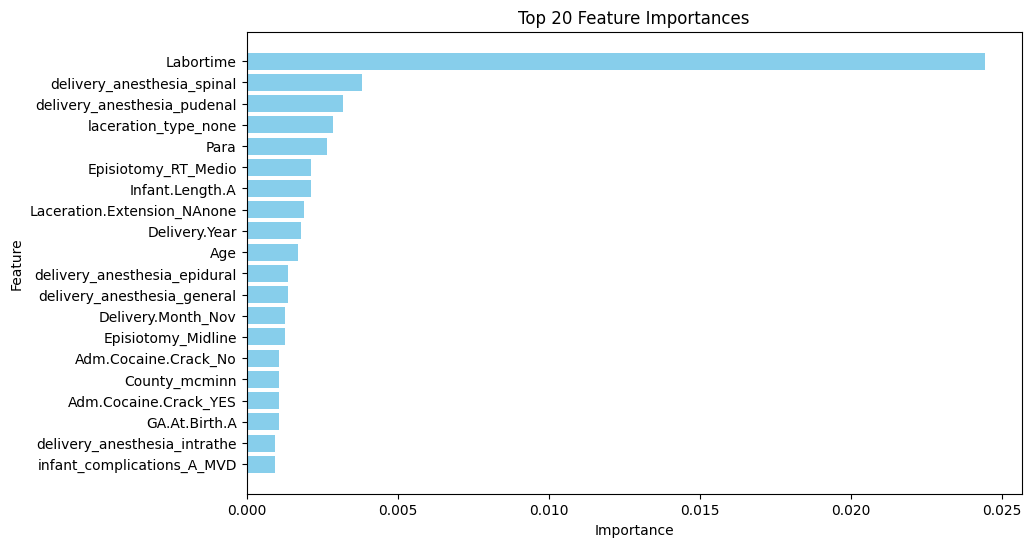

In [26]:
model1,importance1,features_i1,top_features_complete = models.run_Multinomial1(X1_train, X1_test, y1_train, y1_test)

### data : mean

In [27]:
X2_train, X2_test, y2_train, y2_test = helpers.split_and_scale_data(features_mean, labels_mean)

In [28]:
print(Counter(y2_train))

Counter({1: 8608, 2: 1815, 0: 361})


In [29]:
print(Counter(y2_test))

Counter({1: 3726, 2: 757, 0: 139})


In [30]:
X2_train, y2_train = helpers.perform_SMOTE(X2_train, y2_train)
print(Counter(y2_train))

Counter({1: 8608, 2: 8608, 0: 8608})


Mean Accuracy: 0.897 (0.006)
Confusion Matrix:
[[  89    9   41]
 [  52 3576   98]
 [ 152   37  568]]

Classification Report:
{'0': {'precision': 0.3037542662116041, 'recall': 0.6402877697841727, 'f1-score': 0.41203703703703703, 'support': 139.0}, '1': {'precision': 0.9872998343456654, 'recall': 0.9597423510466989, 'f1-score': 0.9733260751224823, 'support': 3726.0}, '2': {'precision': 0.8033946251768034, 'recall': 0.750330250990753, 'f1-score': 0.7759562841530054, 'support': 757.0}, 'accuracy': 0.915837299870186, 'macro avg': {'precision': 0.6981495752446909, 'recall': 0.7834534572738748, 'f1-score': 0.7204397987708416, 'support': 4622.0}, 'weighted avg': {'precision': 0.9366228379563398, 'recall': 0.915837299870186, 'f1-score': 0.9241205130156517, 'support': 4622.0}}


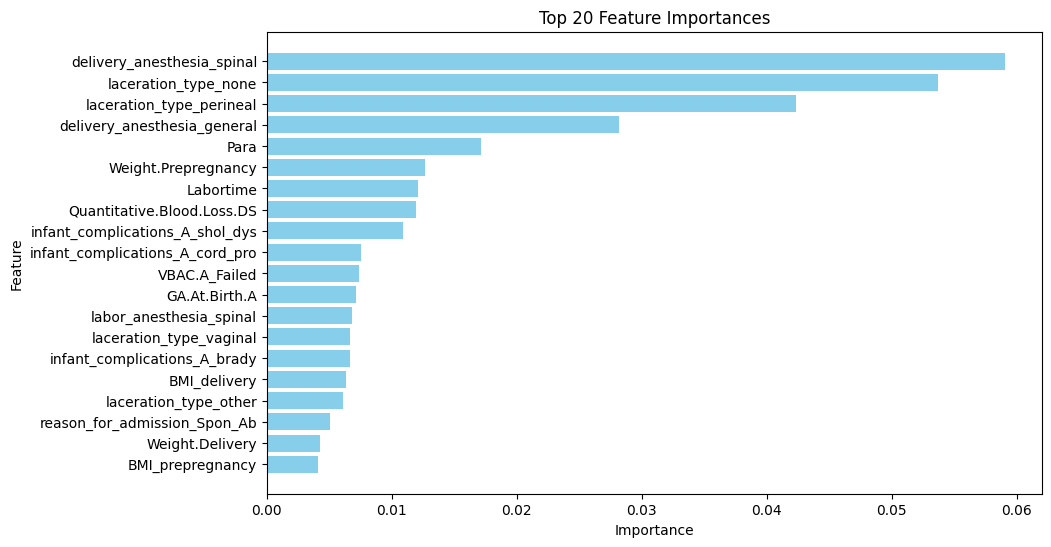

In [31]:
model2,importance2,features_i2,top_features_mean = models.run_Multinomial1(X2_train, X2_test, y2_train, y2_test)

### data:ml

In [32]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features_ml, labels_ml)

In [33]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 8608, 2: 1815, 0: 361})
Counter({1: 3726, 2: 757, 0: 139})


In [34]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


Mean Accuracy: 0.899 (0.005)
Confusion Matrix:
[[  90    9   40]
 [  47 3578  101]
 [ 148   38  571]]

Classification Report:
{'0': {'precision': 0.3157894736842105, 'recall': 0.6474820143884892, 'f1-score': 0.42452830188679247, 'support': 139.0}, '1': {'precision': 0.9870344827586207, 'recall': 0.9602791196994096, 'f1-score': 0.973472996871174, 'support': 3726.0}, '2': {'precision': 0.8019662921348315, 'recall': 0.7542932628797886, 'f1-score': 0.7773995915588836, 'support': 757.0}, 'accuracy': 0.9171354392038079, 'macro avg': {'precision': 0.7015967495258876, 'recall': 0.7873514656558958, 'f1-score': 0.7251336301056167, 'support': 4622.0}, 'weighted avg': {'precision': 0.9365369326583283, 'recall': 0.9171354392038079, 'f1-score': 0.9248509976448146, 'support': 4622.0}}


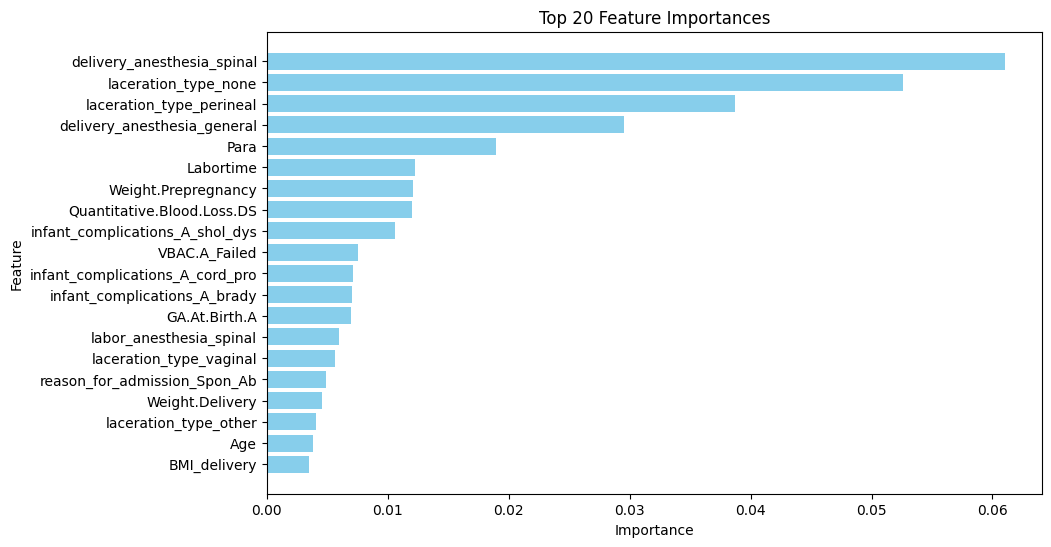

In [35]:
model3,importance3,features_i3,top_features_ml = models.run_Multinomial1(X_train, X_test, y_train, y_test)

The permutation importance for a multinomial logistic regression model provides an indication of how much each feature contributes to the model's predictive power. By permuting each feature and observing the change in performance, you can determine the importance of each feature. This method is model-agnostic and can be applied to any classifier.

In [36]:
coefficients3 = model3.coef_

# Get the intercepts
intercepts3 = model3.intercept_

In [62]:
# Print the coefficients with feature names
print("Coefficients:")

# for i, class_coefficients in enumerate(coefficients3):
#    feature_list = []
#    print(f"\nClass {model3.classes_[i]} coefficients:")
#    for feature, coef in zip(X_train.columns, class_coefficients):
#        print(f"{feature}: {coef:.4f}")
#        feature_list.append(feature)

print("\nIntercepts:")
for i, intercept in enumerate(intercepts3):
    print(f"Class {model3.classes_[i]} intercept: {intercept:.4f}")

Coefficients:

Intercepts:
Class 0 intercept: -3.0418
Class 1 intercept: 5.6573
Class 2 intercept: -2.6156


In [38]:
coefficients3.shape

(3, 238)

In [39]:
len(feature_list)

238

In [40]:
coefficients3_imp = pd.DataFrame(coefficients3)
coefficients3_imp

,0,1,2,3,4,5,6,7,8,9,...,228,229,230,231,232,233,234,235,236,237
0,0.305949,-0.430836,-0.104816,0.048130,-0.012962,-0.155006,-0.030554,-0.271124,0.306052,-0.547854,...,-0.021708,0.141627,-0.006167,0.121451,-0.004182,-0.044000,0.005911,-0.030995,0.012106,0.066083
1,-0.464446,0.164493,0.895552,-0.167100,0.044941,0.017685,-0.215947,0.171974,-0.631621,-0.087450,...,0.025528,-0.085268,-0.000151,-0.202358,0.047640,0.032254,0.010744,-0.015527,0.012684,-0.005680
2,0.158497,0.266342,-0.790735,0.118971,-0.031980,0.137322,0.246501,0.099150,0.325569,0.635304,...,-0.003820,-0.056359,0.006318,0.080907,-0.043459,0.011747,-0.016655,0.046522,-0.024790,-0.060404


In [41]:
coeff_df = pd.DataFrame(coefficients3, columns=X_test.columns)
coeff_df = coeff_df.T

In [42]:
coeff_df.columns = ['emergency', 'vag', 'non-emergency']
coeff_df['max_col'] = coeff_df.idxmax(axis=1)

# Display the updated dataframe
print(coeff_df)

                               emergency       vag  non-emergency  \
Age                             0.305949 -0.464446       0.158497   
Gravida                        -0.430836  0.164493       0.266342   
Para                           -0.104816  0.895552      -0.790735   
Number.of.Babies.In.Womb        0.048130 -0.167100       0.118971   
Delivery.Year                  -0.012962  0.044941      -0.031980   
...                                  ...       ...            ...   
Provider.On.Admission_unknown  -0.044000  0.032254       0.011747   
Ethnicity_D                     0.005911  0.010744      -0.016655   
Ethnicity_H                    -0.030995 -0.015527       0.046522   
Ethnicity_O                     0.012106  0.012684      -0.024790   
Ethnicity_U                     0.066083 -0.005680      -0.060404   

                                     max_col  
Age                                emergency  
Gravida                        non-emergency  
Para                          

In [43]:
coeff_df.to_csv('../data/coef_df_ml_mlr.csv')

### data: mice

In [44]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features_mice, labels_mice)

In [45]:
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 8608, 2: 1815, 0: 361})
Counter({1: 3726, 2: 757, 0: 139})


In [46]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


Mean Accuracy: 0.893 (0.005)
Confusion Matrix:
[[  93    8   38]
 [  45 3570  111]
 [ 131   40  586]]

Classification Report:
{'0': {'precision': 0.34572490706319703, 'recall': 0.6690647482014388, 'f1-score': 0.45588235294117646, 'support': 139.0}, '1': {'precision': 0.9867330016583747, 'recall': 0.9581320450885669, 'f1-score': 0.9722222222222222, 'support': 3726.0}, '2': {'precision': 0.7972789115646258, 'recall': 0.774108322324967, 'f1-score': 0.7855227882037533, 'support': 757.0}, 'accuracy': 0.9192990047598443, 'macro avg': {'precision': 0.7099122734287325, 'recall': 0.8004350385383242, 'f1-score': 0.7378757877890507, 'support': 4622.0}, 'weighted avg': {'precision': 0.9364264522534207, 'recall': 0.9192990047598443, 'f1-score': 0.9261160531650942, 'support': 4622.0}}


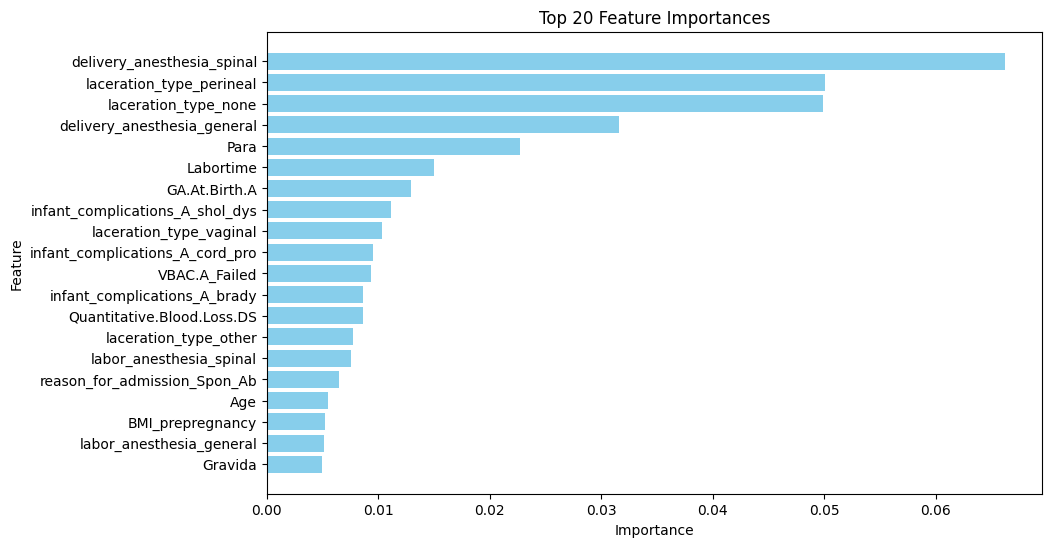

In [47]:
model4,importance4,features_i4,top_features_mice = models.run_Multinomial1(X_train, X_test, y_train, y_test)

In [48]:
y_pred_mice = model4.predict(X_test)

In [49]:
y_pred_mice_prob = model4.predict_proba(X_test)

In [50]:
from sklearn import metrics
def confusion_matrix2(y_true, y_pred):
    plt.figure(figsize = (16,8))
    unique_labels = np.unique(y_true)
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True,fmt='d',
                annot_kws={"size": 18},xticklabels = unique_labels, yticklabels = unique_labels, cmap = 'summer')
    plt.xlabel('Predicted Labels',fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.xticks(fontsize=16)  # Change the size of x-tick labels
    plt.yticks(fontsize=16)
    plt.show()

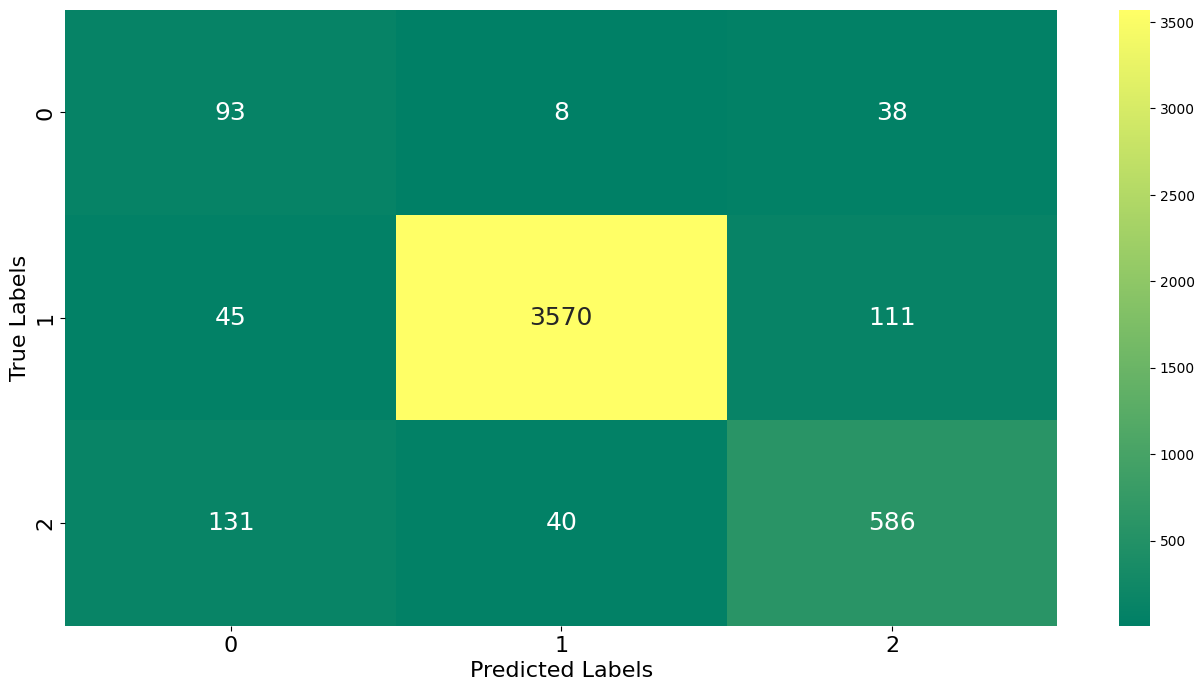

In [51]:
confusion_matrix2(y_test,y_pred_mice)

In [52]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_mice))
print('Accuracy:', metric.accuracy(y_test, y_pred_mice))
print('Precision:', metric.macro_precision(y_test, y_pred_mice))
print('Recall:', metric.macro_recall(y_test, y_pred_mice))
print('F1:', metric.macro_f1(y_test, y_pred_mice))

AUC: {0: 0.8149026618544557, 1: 0.952280308258569, 2: 0.8677786113565327}
Accuracy: 0.9192990047598443
Precision: 0.7099122725478377
Recall: 0.8004350365072699
F1: 0.737875303598092


In [53]:

from tensorflow.keras.utils import to_categorical

In [54]:
# Create a dataframe with the observed and predicted counts
observed_counts = pd.DataFrame({'Observed': y_test})
predicted_counts = pd.DataFrame(y_pred_mice_prob, columns=['Class_0', 'Class_1', 'Class_2'])
predicted_counts['Predicted'] = y_pred_mice


In [55]:
from scipy.stats import chi2
# Calculate expected counts
expected_counts = predicted_counts.groupby('Predicted').sum().values

# Calculate observed counts
observed_counts = pd.get_dummies(observed_counts['Observed']).sum().values

# Compute Pearson Chi-Square statistic
chi_square_stat = ((observed_counts - expected_counts)**2 / expected_counts).sum()
p_value_chi_square = chi2.sf(chi_square_stat, df=len(observed_counts)-1)


In [56]:
observed_counts

array([ 139, 3726,  757])

In [57]:
expected_counts

array([[ 215.93659119,   12.14883253,   40.91457628],
       [  36.29485358, 3490.87730271,   90.8278437 ],
       [  80.4196223 ,   43.09675313,  611.48362458]])

In [58]:
result = permutation_importance(model4, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

In [59]:
result

{'importances_mean': array([ 5.47382086e-03,  4.93292947e-03,  2.26741670e-02,  1.03851147e-03,
         1.73085244e-04,  3.46170489e-04,  3.22371268e-03,  1.10341843e-03,
         1.29164864e-02,  9.73604500e-04,  1.68758113e-03,  1.06014712e-03,
         8.63262657e-03,  1.36304630e-03,  3.76460407e-03,  5.17092168e-03,
         1.49935093e-02, -2.16356556e-05,  6.62051060e-02,  4.75984422e-04,
         3.09389875e-03,  1.38468196e-03,  3.15447858e-02,  3.24534833e-03,
         1.38468196e-03,  7.52920814e-03,  4.28385980e-03,  5.12765037e-03,
        -1.94720900e-04,  4.98701861e-02,  1.03202077e-02,  5.00865426e-02,
         3.00735612e-03,  1.94720900e-04,  7.68065772e-03,  8.65426222e-03,
         3.72133276e-03,  4.32713111e-04,  9.54132410e-03,  3.80787538e-03,
         7.78883600e-04,  2.20683687e-03,  1.11423626e-02,  5.40891389e-04,
         8.65426222e-04,  2.44482908e-03,  1.18996106e-03,  6.44742536e-03,
         3.24534833e-03, -3.67806145e-04,  2.03375162e-03,  3.894418

In [63]:
df_mice.shape

(15406, 90)